In [1]:
!pip install -q timm #for pretrained models
!pip install -q albumentations==0.4.6 #for image augmentations
!pip install -q transformers #for learning rate scheduler
!pip -q install astropy # for working with .fits data

# Importing the libraries

In [2]:
import astropy
from astropy.io import fits
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import model_selection

import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import glob
import sklearn
import math
import random

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim

from transformers import get_cosine_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#make sure device is "cuda"
print(device)

cuda


# Setting seed for reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(42)

# Extracting Data

In [4]:
file = tarfile.open('../input/lens-find/lens_finding.tgz')
file.extractall("data/")

In [5]:
df = pd.read_csv("./data/SpaceBasedTraining/classifications.csv")
df.ID = df.ID.astype(str)
df.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,8.633760e-10,171,195.429
1,100001,1,1.317890e-10,294,855.589
2,100002,1,4.877250e-12,140,486.113
3,100003,1,1.440160e-09,1500,10467.400
4,100004,0,2.197350e-11,0,0.000


In [6]:
images_present = os.listdir("./data/SpaceBasedTraining/files")

In [7]:
all_images = []
for i in images_present:
    all_images.append(i.split('imageEUC_VIS-')[-1].split('.fits')[0])

In [8]:
#making sure only use the rows of the dataframe if corresponding image is available
df = df[df.ID.isin(all_images)].reset_index(drop = True)

In [9]:
img_pths = "./data/SpaceBasedTraining/files/imageEUC_VIS-"
df['path'] = [ f"{img_pths}{x}.fits" for x in df["ID"]]

# Splitting the data in 10 equal parts

In [10]:
y = df.is_lens.values
kf = model_selection.StratifiedKFold(n_splits =10, random_state=42 , shuffle=True)

for f,(t,v) in enumerate(kf.split(X=df,y=y)):
    df.loc[v,'fold'] = f

# Keep one part (10%) for test, rest (90%) fror training

In [11]:
test = df[df.fold == 0].reset_index(drop = True)

In [12]:
train = df[df.fold != 0].reset_index(drop = True)

# Creating five folds in train data for Cross validation

In [13]:
y = train.is_lens.values
kf = model_selection.StratifiedKFold(n_splits =5, random_state=42 , shuffle=True)

for f,(t,v) in enumerate(kf.split(X=train,y=y)):
    train.loc[v,'fold'] = f

# Best Hyperparameters found

In [14]:
image_size = 100
pretrained_model = 'tf_efficientnet_b2_ns'
lr=1e-3
weight_decay = 1e-6
epochs= 15
warmup_epochs = 3

# Augmentations
In the training augmentations, Random Crop is introduced as a augmentation, which have a probability of 0.5 to add or not, HorizontalFlip & VerticalFlip have a probability of 0.25 to occur

In [15]:
train_aug = A.Compose(
    [  
        A.RandomCrop(80,80,p=0.5),   
        A.Resize(image_size,image_size,p=1.0),
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        ToTensorV2()
    ]
)
val_aug = A.Compose(
    [ 
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

# Feature Engg the meta features
The model uses both image data and the meta data provided in the csv file to predict the final output.
For the proper working of the features I make the features to range from 0 to 1 by diving them by the biggest value of that feature (see the feature_engg() function to understand clearly)

In [16]:
meta_features = ["Einstein_area" , "numb_pix_lensed_image" , "flux_lensed_image_in_sigma"]

In [17]:
def feature_engg(meta_data):
    data = meta_data.copy()
    data.Einstein_area = data.Einstein_area/(data.Einstein_area.max())
    data.numb_pix_lensed_image = data.numb_pix_lensed_image/(data.numb_pix_lensed_image.max())
    data.flux_lensed_image_in_sigma = data.flux_lensed_image_in_sigma/(data.flux_lensed_image_in_sigma.max())

    return data

# Dataset Class

In [18]:
class Lens(Dataset):
    def __init__(self,df , augs):
        self.df = df
        self.augs = augs
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        img =  fits.open(self.df.path[idx])
        image =  img[0].data
        image = image/np.max(image)
        image = np.expand_dims(image , axis = 2)
        label = self.df.is_lens[idx]
        transformed = self.augs(image=image)
        image = transformed['image']
        
        meta = torch.tensor(self.df[meta_features].iloc[idx,:].values, dtype=torch.float)
    
        return image , torch.tensor(label) , meta

# Visualising what our dataset returns

target -> tensor([0])
meta features -> tensor([[0.4891, 0.0000, 0.0000]])


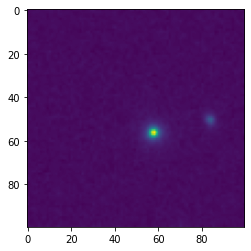

In [19]:
train_data = feature_engg(df[df.fold == 2])
train_data = Lens(train_data.reset_index(drop=True),train_aug)
train_loader = DataLoader(train_data,
                         shuffle=True,
                    batch_size=1)
a,b,c = next(iter(train_loader))

plt.imshow(a.squeeze(0).permute(1,2,0))
print(f'target -> {b}')
print(f'meta features -> {c}')
plt.show()

# The Model
The model uses transfer learning and uses both the image and meta features for final prediction.
Only using image was giving good results but when I added the meta fetures it was giving the best.

Before the final layer of the model, the meta fetures are also go through a Linear layer and both the image's and meta feature's embeddings are concatenated before giving the final prediction.

![Full Model Architecture](https://i.imgur.com/wyZzVLc.png)

In [20]:
class Model(nn.Module):
    def __init__(self,pretrained = True):
        super().__init__()
        self.backbone = timm.create_model(pretrained_model, pretrained=pretrained, num_classes=0, drop_rate=0.0,global_pool='',in_chans=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.lin2 = nn.Linear(1408+3,1)
        self.do = nn.Dropout(p=0.4)
        self.lin1 = nn.Linear(3,3)
    
    def forward(self,image , feat):
        image = self.backbone(image)     
        image = self.pool(image)
        image = image.view(image.shape[0], -1)
        
        image = self.do(image)
        feat = self.lin1(feat)
        x = torch.cat([image , feat ], dim = 1)#concat embeddings
        x = self.lin2(x)
        return x

# Helper Functions

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
def train_one_epoch(train_loader,model,optimizer,criterion,e,epochs,scheduler):
    '''Trains the model for a single epoch and returns Loss,Accuracy, AUC for that epoch'''

    losses = AverageMeter()
    scores1 = AverageMeter()
    scores2 = AverageMeter()
    model.train()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    
    for step,(image,labels , feat) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels= labels.to(device)
        feat = feat.to(device)
        
        output = model(image , feat)
        batch_size = labels.size(0)
        
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = roc_auc_score(targets, outputs)
            accuracy = accuracy_score(targets, outputs > 0.5)
            losses.update(loss.item(), batch_size)
            scores1.update(auc.item(), batch_size)
            scores2.update(accuracy.item(), batch_size)
            
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step() 
            
            global_step += 1
        
            loop.set_description(f"Epoch {e+1}/{epochs}")
            loop.set_postfix(loss = loss.item(), auc = auc.item(), acc = accuracy.item() ,stage = 'train')
        
            
        except ValueError:
            pass     
    return losses.avg,scores1.avg,scores2.avg

In [23]:
def val_one_epoch(loader,model,criterion):
    '''Validates the model for a single epoch and returns Loss,Accuracy, AUC for that epoch'''
    losses = AverageMeter()
    scores1 = AverageMeter()
    scores2 = AverageMeter()
    model.eval()
    global_step = 0
    loop = tqdm(enumerate(loader),total = len(loader))
    
    for step,(image,labels,feat) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels = labels.to(device)
        feat = feat.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            output = model(image , feat)
        loss =criterion(output,labels.float()) 
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = roc_auc_score(targets, outputs)
            accuracy = accuracy_score(targets, outputs > 0.5)
            losses.update(loss.item(), batch_size)
            scores1.update(auc.item(), batch_size)
            scores2.update(accuracy.item(), batch_size)
            loop.set_postfix(loss = loss.item(), auc = auc.item(), acc = accuracy.item() ,stage = 'val')
            global_step += 1
        except ValueError:
            pass

    return losses.avg,scores1.avg,scores2.avg

In [24]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Training Loop

In [25]:
def fit(m,fold_n,training_batch_size=16,validation_batch_size=32):
    
    #IMPORTANT
    # we have to calculate feature engg for train and validation separately and not on the full csv file, 
    #else there may be data leakage
    train_data= feature_engg(train[train.fold != fold_n])
    val_data= feature_engg(train[train.fold == fold_n])
    
    train_data= Lens(train_data.reset_index(drop=True),train_aug)
    val_data= Lens(val_data.reset_index(drop=True) ,val_aug)
    
    train_loader = DataLoader(train_data,
                             shuffle=True,
                        num_workers=4,
                        batch_size=training_batch_size,drop_last = True,pin_memory=True)
    valid_loader = DataLoader(val_data,
                             shuffle=False,
                        num_workers=4,
                        batch_size=validation_batch_size,drop_last = False ,pin_memory=True)
    
    
    criterion1=nn.BCEWithLogitsLoss() # Loss function
    optimizer = optim.AdamW(m.parameters(), lr=lr , weight_decay = weight_decay ) 
    
    num_train_steps = math.ceil(len(train_loader))
    num_train_steps = math.ceil(len(train_loader))
    num_warmup_steps= num_train_steps * warmup_epochs
    num_training_steps=int(num_train_steps * epochs)
    scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps)
    
    loop = range(epochs)
    for e in loop:
      
        train_loss,train_auc,tacc = train_one_epoch(train_loader,m,optimizer,criterion1,e,epochs,scheduler )

        print(f'For epoch {e+1}/{epochs}')
        print(f'average train_loss {train_loss}')
        print(f'average train_auc {train_auc}' )
        print(f'average train_acc {tacc}' )
        
        val_loss,val_auc,vacc = val_one_epoch(valid_loader,m,criterion1)
        
        print(f'avarage val_loss { val_loss }')
        print(f'avarage val_auc {val_auc}')
        print(f'avarage val_acc {vacc}')

        torch.save(m.state_dict(),OUTPUT_DIR+ f'Fold {fold_n} val_auc {val_auc}.pth')

In [26]:
for i in range(5):
    model = Model(True)
    model = model.to(device)
    fit(model, i)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_ns-00306e48.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b2_ns-00306e48.pth


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 1/15
average train_loss 0.4868282907846692
average train_auc 0.80449708585164
average train_acc 0.7420229244114003


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.3385516375671198
avarage val_auc 0.9127783762290607
avarage val_acc 0.8379629629629629


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 2/15
average train_loss 0.3621509206634767
average train_auc 0.9121506694462092
average train_acc 0.8188506815365552


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.3455644445654787
avarage val_auc 0.9231061636525335
avarage val_acc 0.8339506172839506


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 3/15
average train_loss 0.327154489888782
average train_auc 0.9306156349666562
average train_acc 0.8450649752475248


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.32161099130724685
avarage val_auc 0.9298410500503815
avarage val_acc 0.8296296296296296


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 4/15
average train_loss 0.3035747603189813
average train_auc 0.9411779861911199
average train_acc 0.852132262051916


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.3622891518804762
avarage val_auc 0.9355147932469642
avarage val_acc 0.8299382716049383


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 5/15
average train_loss 0.28045364614981827
average train_auc 0.9469531581420492
average train_acc 0.8656404702970297


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.29836775016637496
avarage val_auc 0.9431813611636378
avarage val_acc 0.8595679012345679


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 6/15
average train_loss 0.26917502082782757
average train_auc 0.9517003601692263
average train_acc 0.8705855018587361


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2761770912894496
avarage val_auc 0.9512581155214145
avarage val_acc 0.8672839506172839


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 7/15
average train_loss 0.25207807200425997
average train_auc 0.9560641280474205
average train_acc 0.8836633663366337


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2468374467190401
avarage val_auc 0.9569085927949763
avarage val_acc 0.8873456790123457


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 8/15
average train_loss 0.23402176851332926
average train_auc 0.9622482749648594
average train_acc 0.8939511138613861


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.24059301018714904
avarage val_auc 0.9588019620616504
avarage val_acc 0.8935185185185185


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 9/15
average train_loss 0.22240036756309292
average train_auc 0.9681646747834638
average train_acc 0.8975931677018634


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.23713020829506862
avarage val_auc 0.961206731838644
avarage val_acc 0.8870370370370371


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 10/15
average train_loss 0.20566035519101933
average train_auc 0.9719778972058012
average train_acc 0.9072156983930779


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.21450541961340255
avarage val_auc 0.9664110510943706
avarage val_acc 0.9021604938271605


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 11/15
average train_loss 0.1894328626994002
average train_auc 0.9764365085710879
average train_acc 0.914632262051916


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.22171090970068802
avarage val_auc 0.965199932790698
avarage val_acc 0.9040123456790123


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 12/15
average train_loss 0.17295042188759746
average train_auc 0.9782683045948829
average train_acc 0.9228805693069307


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.22335388991567823
avarage val_auc 0.9635489804013543
avarage val_acc 0.8987654320987655


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 13/15
average train_loss 0.1612374269965084
average train_auc 0.9816298698200073
average train_acc 0.9272642679900744


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2343009505374932
avarage val_auc 0.9654690943062783
avarage val_acc 0.8984567901234568


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 14/15
average train_loss 0.1539308319975736
average train_auc 0.9828055695677768
average train_acc 0.9303924598269468


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.22159323298636777
avarage val_auc 0.9674745175953602
avarage val_acc 0.9058641975308642


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 15/15
average train_loss 0.15036213265122547
average train_auc 0.9841623020326723
average train_acc 0.9324074074074075


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.22004111585793673
avarage val_auc 0.9676701333804952
avarage val_acc 0.9092592592592592


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 1/15
average train_loss 0.4953054640225171
average train_auc 0.7917080553000636
average train_acc 0.7272304832713755


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.35166917228036454
avarage val_auc 0.9108057356804125
avarage val_acc 0.8342592592592593


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 2/15
average train_loss 0.35967686397044296
average train_auc 0.9146182554177293
average train_acc 0.8268455334987593


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.33919755625136105
avarage val_auc 0.9351756706176371
avarage val_acc 0.828395061728395


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 3/15
average train_loss 0.3414558753038871
average train_auc 0.9207992290822222
average train_acc 0.8344175960346965


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.34266231858435975
avarage val_auc 0.9140688926217551
avarage val_acc 0.8391975308641976


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 4/15
average train_loss 0.31782237886274617
average train_auc 0.9343924318831393
average train_acc 0.8444857496902106


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2637499882667153
avarage val_auc 0.952774317131819
avarage val_acc 0.8753086419753087


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 5/15
average train_loss 0.2859183708044051
average train_auc 0.9451625904595824
average train_acc 0.865462158808933


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.24957540646701315
avarage val_auc 0.9518872102830235
avarage val_acc 0.8787037037037037


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 6/15
average train_loss 0.28059920863845883
average train_auc 0.9469932304681997
average train_acc 0.8671199011124846


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.23877622286478678
avarage val_auc 0.9585114885585879
avarage val_acc 0.8885802469135803


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 7/15
average train_loss 0.2593072305329972
average train_auc 0.9556340213284662
average train_acc 0.8766975308641975


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.23533191955015983
avarage val_auc 0.9581720604278869
avarage val_acc 0.8919753086419753


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 8/15
average train_loss 0.24334582103195018
average train_auc 0.9603252628662606
average train_acc 0.8828898514851485


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2074512386901511
avarage val_auc 0.9667485074935779
avarage val_acc 0.8959876543209877


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 9/15
average train_loss 0.22589145490698875
average train_auc 0.9663905904263714
average train_acc 0.9001703841387856


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2180445686718564
avarage val_auc 0.9672809047751411
avarage val_acc 0.8972222222222223


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 10/15
average train_loss 0.21022844072523536
average train_auc 0.9698208411157055
average train_acc 0.9038521039603961


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.1959822333463824
avarage val_auc 0.9707292694794142
avarage val_acc 0.9117283950617284


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 11/15
average train_loss 0.19641835015032288
average train_auc 0.973727878614312
average train_acc 0.9113875154511742


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.18911169611354484
avarage val_auc 0.972690999498995
avarage val_acc 0.9141975308641975


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 12/15
average train_loss 0.18030601005531544
average train_auc 0.9769533768490822
average train_acc 0.9169499381953028


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.18716020955255738
avarage val_auc 0.9746340010001936
avarage val_acc 0.9135802469135802


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 13/15
average train_loss 0.16727703653132864
average train_auc 0.9791007040426186
average train_acc 0.9230173482032218


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.1934851319897046
avarage val_auc 0.9737127784807335
avarage val_acc 0.9145061728395062


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 14/15
average train_loss 0.15420649563294309
average train_auc 0.9830123259578716
average train_acc 0.9291460396039604


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.19513399481405447
avarage val_auc 0.9731315824758282
avarage val_acc 0.9104938271604939


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 15/15
average train_loss 0.1494794941848572
average train_auc 0.9829701837155255
average train_acc 0.9365683229813665


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.19623407722554273
avarage val_auc 0.9735808827834693
avarage val_acc 0.9135802469135802


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 1/15
average train_loss 0.48404745387353176
average train_auc 0.804711145621993
average train_acc 0.7352441285537701


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.3737936136163311
avarage val_auc 0.906364914642178
avarage val_acc 0.8169753086419753


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 2/15
average train_loss 0.3575221232719498
average train_auc 0.9141282693688336
average train_acc 0.8215501237623762


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.31968669008325645
avarage val_auc 0.9327624309478844
avarage val_acc 0.842283950617284


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 3/15
average train_loss 0.3294666077301588
average train_auc 0.929455341990108
average train_acc 0.8392305315203955


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.31344998765874793
avarage val_auc 0.934112341377206
avarage val_acc 0.8373456790123457


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 4/15
average train_loss 0.31392950614416365
average train_auc 0.9372625556683417
average train_acc 0.8451423267326733


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.25924000276459586
avarage val_auc 0.951137382983789
avarage val_acc 0.8688271604938271


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 5/15
average train_loss 0.29260628676916733
average train_auc 0.9432275825166159
average train_acc 0.8612918215613383


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.25619544158747165
avarage val_auc 0.9514386564467289
avarage val_acc 0.8691358024691358


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 6/15
average train_loss 0.2757875203514601
average train_auc 0.9473145228327775
average train_acc 0.8665686881188119


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.26179052863591984
avarage val_auc 0.9489666559430082
avarage val_acc 0.8746913580246913


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 7/15
average train_loss 0.26073162961695895
average train_auc 0.954784518630435
average train_acc 0.8797184405940595


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.23950979981893375
avarage val_auc 0.9567508360953759
avarage val_acc 0.8876543209876543


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 8/15
average train_loss 0.24344071771293213
average train_auc 0.9582742874887732
average train_acc 0.8868641439205955


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2268341463289143
avarage val_auc 0.9621095265563916
avarage val_acc 0.8895061728395062


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 9/15
average train_loss 0.22894050988365236
average train_auc 0.9653090201413745
average train_acc 0.8929233621755254


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.23589639965398812
avarage val_auc 0.9601467157788454
avarage val_acc 0.8904320987654321


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 10/15
average train_loss 0.21162224472344587
average train_auc 0.9682854509527379
average train_acc 0.9021840148698885


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.23065383894208036
avarage val_auc 0.9668373232967675
avarage val_acc 0.8962962962962963


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 11/15
average train_loss 0.1968596959024409
average train_auc 0.9731372109590168
average train_acc 0.9084212158808933


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2204919217913239
avarage val_auc 0.9688990721576951
avarage val_acc 0.9027777777777778


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 12/15
average train_loss 0.17991483116765386
average train_auc 0.9766862144928918
average train_acc 0.9190217391304348


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.20616980701868917
avarage val_auc 0.969663287305267
avarage val_acc 0.9027777777777778


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 13/15
average train_loss 0.16873156442134468
average train_auc 0.9799046679486506
average train_acc 0.9256944444444445


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2011341064248556
avarage val_auc 0.9701491724209064
avarage val_acc 0.9055555555555556


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 14/15
average train_loss 0.15564109244797153
average train_auc 0.9826934893838476
average train_acc 0.9294653893695921


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.20366820184352957
avarage val_auc 0.9711369566427682
avarage val_acc 0.9089506172839507


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 15/15
average train_loss 0.15848537338920668
average train_auc 0.9819402677557889
average train_acc 0.927586741016109


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2033370392649998
avarage val_auc 0.9709084206366432
avarage val_acc 0.908641975308642


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 1/15
average train_loss 0.47759142799407056
average train_auc 0.8157203222071238
average train_acc 0.7470496894409938


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.3850514500229447
avarage val_auc 0.8895109855104288
avarage val_acc 0.8049382716049382


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 2/15
average train_loss 0.3534187870342492
average train_auc 0.9188943341011188
average train_acc 0.8269052044609665


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.37978988849086526
avarage val_auc 0.8966034543406052
avarage val_acc 0.8098765432098766


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 3/15
average train_loss 0.3328668513838549
average train_auc 0.9259747688474399
average train_acc 0.8343167701863354


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.3063870427049237
avarage val_auc 0.9347603691199543
avarage val_acc 0.850925925925926


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 4/15
average train_loss 0.31568026482874967
average train_auc 0.9342355231359865
average train_acc 0.8479938271604939


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.29647782702504855
avarage val_auc 0.9405653661388864
avarage val_acc 0.8567901234567902


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 5/15
average train_loss 0.28066783039743853
average train_auc 0.9472536512831546
average train_acc 0.868167701863354


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2840230247856658
avarage val_auc 0.9386039329282476
avarage val_acc 0.8635802469135803


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 6/15
average train_loss 0.261388805023406
average train_auc 0.954446534261349
average train_acc 0.877854938271605


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2792911376114245
avarage val_auc 0.9510773220820347
avarage val_acc 0.8753086419753087


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 7/15
average train_loss 0.24462562327000356
average train_auc 0.9591178195859906
average train_acc 0.8878244746600742


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.24317728074980371
avarage val_auc 0.9602440299130398
avarage val_acc 0.8876543209876543


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 8/15
average train_loss 0.22605757001064605
average train_auc 0.9647106982811274
average train_acc 0.8981654228855721


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.23518593200930843
avarage val_auc 0.9594501424942751
avarage val_acc 0.8950617283950617


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 9/15
average train_loss 0.2123653749015547
average train_auc 0.9696616821152152
average train_acc 0.9045074349442379


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2341154318532826
avarage val_auc 0.9623629541835892
avarage val_acc 0.8919753086419753


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 10/15
average train_loss 0.19526390096972288
average train_auc 0.9749157277964663
average train_acc 0.9124534739454094


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2180059905405398
avarage val_auc 0.9664715199855932
avarage val_acc 0.9024691358024691


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 11/15
average train_loss 0.18122951159440673
average train_auc 0.976017537123485
average train_acc 0.9172087980173482


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.20972162518236373
avarage val_auc 0.9694841333317882
avarage val_acc 0.9070987654320988


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 12/15
average train_loss 0.16760985017264876
average train_auc 0.9803276768897909
average train_acc 0.9227441285537701


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.20285496983999088
avarage val_auc 0.9701803249679135
avarage val_acc 0.912962962962963


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 13/15
average train_loss 0.15487770483941024
average train_auc 0.9833332121203872
average train_acc 0.9316914498141264


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.20691165456801286
avarage val_auc 0.969380810057637
avarage val_acc 0.9126543209876543


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 14/15
average train_loss 0.1425730196971188
average train_auc 0.9851957478543186
average train_acc 0.9357982673267327


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.20278726989104423
avarage val_auc 0.9699206971835843
avarage val_acc 0.9123456790123456


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 15/15
average train_loss 0.1456945049362961
average train_auc 0.9843743427851235
average train_acc 0.9368029739776952


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.20209347550515774
avarage val_auc 0.9699730026951286
avarage val_acc 0.9148148148148149


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 1/15
average train_loss 0.48463885098363385
average train_auc 0.8021940402981297
average train_acc 0.7475991325898389


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.3409743809405668
avarage val_auc 0.9108304124732496
avarage val_acc 0.8342592592592593


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 2/15
average train_loss 0.3718340286368774
average train_auc 0.9076181975810231
average train_acc 0.8199349442379182


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2922134888760837
avarage val_auc 0.9335263058498361
avarage val_acc 0.8537037037037037


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 3/15
average train_loss 0.34246268144596625
average train_auc 0.9219082283400054
average train_acc 0.8327660891089109


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2772460699081421
avarage val_auc 0.9426191621025783
avarage val_acc 0.870679012345679


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 4/15
average train_loss 0.3109069102718892
average train_auc 0.934885848339959
average train_acc 0.8498145859085291


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.26954531294328193
avarage val_auc 0.9537141282532414
avarage val_acc 0.8861111111111111


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 5/15
average train_loss 0.28957675277770306
average train_auc 0.9431449097831083
average train_acc 0.8649844720496894


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2543693749992936
avarage val_auc 0.9583902265807651
avarage val_acc 0.8830246913580246


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 6/15
average train_loss 0.26821802859050675
average train_auc 0.9521910940830901
average train_acc 0.8751545117428925


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2286075054127493
avarage val_auc 0.9612373332617559
avarage val_acc 0.8938271604938272


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 7/15
average train_loss 0.25681636203080416
average train_auc 0.9568760086860331
average train_acc 0.8797184405940595


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.23201599680347207
avarage val_auc 0.9650863071646616
avarage val_acc 0.8932098765432098


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 8/15
average train_loss 0.2442791254685065
average train_auc 0.9631325353316097
average train_acc 0.8861882716049383


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.21856992060755506
avarage val_auc 0.9665437272969268
avarage val_acc 0.9006172839506172


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 9/15
average train_loss 0.2224790080346995
average train_auc 0.968043369096611
average train_acc 0.8996141975308642


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.2057268132398158
avarage val_auc 0.9708429698851487
avarage val_acc 0.9067901234567901


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 10/15
average train_loss 0.20819179516109587
average train_auc 0.970452525035081
average train_acc 0.9056281094527363


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.19140029571674488
avarage val_auc 0.9727081796958197
avarage val_acc 0.9132716049382716


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 11/15
average train_loss 0.19013457608550824
average train_auc 0.9751057836889121
average train_acc 0.9149412855377008


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.1884268088841144
avarage val_auc 0.9752186554769823
avarage val_acc 0.9126543209876543


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 12/15
average train_loss 0.17265550534259344
average train_auc 0.9797545916164424
average train_acc 0.9214108910891089


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.18432683333938504
avarage val_auc 0.9756344208224031
avarage val_acc 0.9206790123456791


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 13/15
average train_loss 0.16554204628149174
average train_auc 0.9804232676398827
average train_acc 0.925388198757764


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.1821356577637755
avarage val_auc 0.9757225627721433
avarage val_acc 0.9182098765432098


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 14/15
average train_loss 0.154536163868311
average train_auc 0.9828725831513935
average train_acc 0.934866790582404


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.18217300207894527
avarage val_auc 0.9761870750417522
avarage val_acc 0.9212962962962963


  0%|          | 0/810 [00:00<?, ?it/s]

For epoch 15/15
average train_loss 0.1533017086250217
average train_auc 0.9826247214535234
average train_acc 0.9308559950556242


  0%|          | 0/102 [00:00<?, ?it/s]

avarage val_loss 0.18213285594074816
avarage val_auc 0.9768519061775269
avarage val_acc 0.9197530864197531


In [27]:
# removing data after use
import shutil
shutil.rmtree("data/")